# Computing saliency masks with the PAIRML saliency library

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
# File       : expl_PAIR_saliency.ipynb
# Modified   : 12.01.2022
# By         : Sandra Carrasco <sandra.carrasco@ai.se>

from torchvision import transforms
import torch
import os, sys
sys.path.append('/workspace/stylegan2-ada-pytorch')
from PIL import Image
from efficientnet_pytorch import EfficientNet
from torchvision.models import resnet50
from melanoma_cnn_efficientnet import Net 
import json 
import numpy as np 
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.pylab as P 
from predict import plot_diagnosis
import utils

import saliency.core as saliency
%matplotlib inline

cuda


## Loading the model 

In [2]:

# Setting up GPU for processing or CPU if GPU isn't available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


arch_r = resnet50(pretrained=True) 
arch_ef = EfficientNet.from_pretrained('efficientnet-b2')

model = Net(arch=arch_ef).eval()
model.load_state_dict(torch.load('/workspace/stylegan2-ada-pytorch/CNN_trainings/melanoma_model_0_0.9225_16_12_train_reals+15melanoma.pth')) 
model.eval()
model.to(device)

# Register hooks for Grad-CAM, which uses the last convolution layer
conv_layer = model.arch._conv_head
conv_layer_outputs = {}

def conv_layer_forward(m, i, o):
    # move the RGB dimension to the last dimension
    conv_layer_outputs[saliency.base.CONVOLUTION_LAYER_VALUES] = torch.movedim(o, 1, 3).detach().cpu().numpy()

def conv_layer_backward(m, i, o):
    # move the RGB dimension to the last dimension
    conv_layer_outputs[saliency.base.CONVOLUTION_OUTPUT_GRADIENTS] = torch.movedim(o[0], 1, 3).detach().cpu().numpy()

conv_layer.register_forward_hook(conv_layer_forward)
conv_layer.register_full_backward_hook(conv_layer_backward)

Loaded pretrained weights for efficientnet-b2


`call_model_function` is how we pass inputs to our model and receive outputs necessary to computer saliency masks.


In [3]:
class_idx_str = 'class_idx_str'
def call_model_function(images, call_model_args=None, expected_keys=None):
    images = utils.PreprocessImages(images)
    target_class_idx =  call_model_args[class_idx_str]
    output = model(images)
    output = torch.sigmoid(output)
    if target_class_idx == 0:
        output = 1-output
    if saliency.base.INPUT_OUTPUT_GRADIENTS in expected_keys:
        # outputs = output[:,target_class_idx]
        grads = torch.autograd.grad(output, images, grad_outputs=torch.ones_like(output))
        grads = torch.movedim(grads[0], 1, 3)
        gradients = grads.detach().cpu().numpy()
        return {saliency.base.INPUT_OUTPUT_GRADIENTS: gradients}
    else:
        one_hot = torch.zeros_like(output)
        one_hot[:,target_class_idx] = 1
        model.zero_grad()
        output.backward(gradient=one_hot, retain_graph=True)
        return conv_layer_outputs


## Load an image and infer

Prediction: tensor([[1.]], device='cuda:0', grad_fn=<SigmoidBackward>)
Prediction class: 1


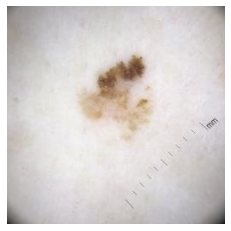

In [4]:
# Load the image
im_orig = utils.LoadImage('/workspace/stylegan2-ada-pytorch/processed_dataset_256_SAM/00000/img00000010.jpg')
im_tensor = utils.PreprocessImages([im_orig]).to(device)
# Show the image
utils.ShowImage(im_orig)

model.to()
predictions = model(im_tensor)
predictions = torch.sigmoid(predictions)
print("Prediction: " + str(predictions))
predictions = torch.tensor([[1-predictions, predictions]], device='cuda:0') 
predictions = predictions.detach().cpu().numpy()
prediction_class = np.argmax(predictions[0])
call_model_args = {class_idx_str: prediction_class}

print("Prediction class: " + str(prediction_class))  # Should be a doberman, class idx = 236


## Vanilla Gradient & SmoothGrad

In [5]:
im = im_orig.astype(np.float32) 

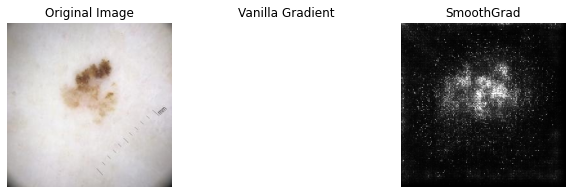

In [6]:

# Construct the saliency object. This alone doesn't do anthing.
gradient_saliency = saliency.GradientSaliency()

# Compute the vanilla mask and the smoothed mask.
vanilla_mask_3d = gradient_saliency.GetMask(im, call_model_function, call_model_args)
smoothgrad_mask_3d = gradient_saliency.GetSmoothedMask(im, call_model_function, call_model_args)

# Call the visualization methods to convert the 3D tensors to 2D grayscale.
vanilla_mask_grayscale = saliency.VisualizeImageGrayscale(vanilla_mask_3d)
smoothgrad_mask_grayscale = saliency.VisualizeImageGrayscale(smoothgrad_mask_3d)

# Set up matplot lib figures.
ROWS = 1
COLS = 3
UPSCALE_FACTOR = 10
P.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))
# Show original image
utils.ShowImage(im_orig, title='Original Image', ax=P.subplot(ROWS, COLS, 1))
# Render the saliency masks.
utils.ShowGrayscaleImage(vanilla_mask_grayscale, title='Vanilla Gradient', ax=P.subplot(ROWS, COLS, 2))
utils.ShowGrayscaleImage(smoothgrad_mask_grayscale, title='SmoothGrad', ax=P.subplot(ROWS, COLS, 3))

### Integrated Gradients & SmoothGrad

For saliency methods that compute gradients along a path (e.g. Integrated Gradients), we can pass a batch_size parameter, which will batch the different steps along the path together so that the model isn't called for each individual step. When using this parameter, be sure that you are not overloading memory, as a very large batch size could crash the program.

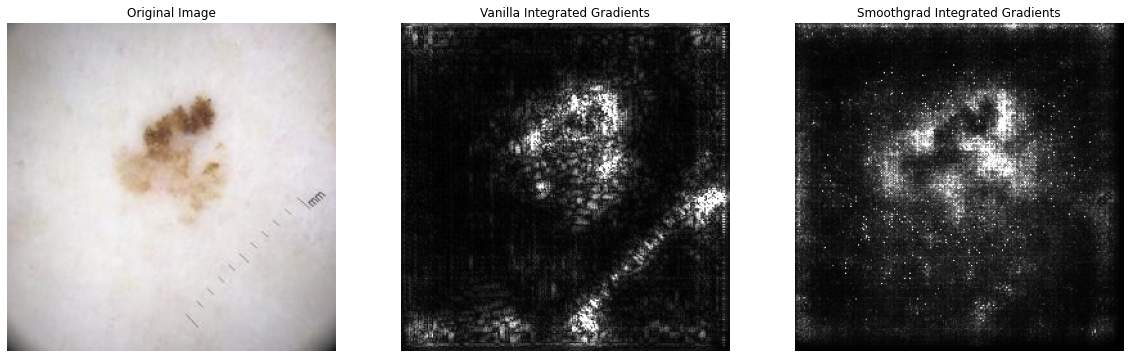

In [9]:
# Construct the saliency object. This alone doesn't do anthing.
integrated_gradients = saliency.IntegratedGradients()

# Baseline is a black image.
baseline = np.zeros(im.shape)

# Compute the vanilla mask and the smoothed mask.
vanilla_integrated_gradients_mask_3d = integrated_gradients.GetMask(
  im, call_model_function, call_model_args, x_steps=25, x_baseline=baseline, batch_size=20)
# Smoothed mask for integrated gradients will take a while since we are doing nsamples * nsamples computations.
smoothgrad_integrated_gradients_mask_3d = integrated_gradients.GetSmoothedMask(
  im, call_model_function, call_model_args, x_steps=25, x_baseline=baseline, batch_size=20)

# Call the visualization methods to convert the 3D tensors to 2D grayscale.
vanilla_mask_grayscale = saliency.VisualizeImageGrayscale(vanilla_integrated_gradients_mask_3d)
smoothgrad_mask_grayscale = saliency.VisualizeImageGrayscale(smoothgrad_integrated_gradients_mask_3d)

# Set up matplot lib figures.
ROWS = 1
COLS = 3
UPSCALE_FACTOR = 20
P.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

# Show original image
utils.ShowImage(im_orig, title='Original Image', ax=P.subplot(ROWS, COLS, 1))

# Render the saliency masks.
utils.ShowGrayscaleImage(vanilla_mask_grayscale, title='Vanilla Integrated Gradients', ax=P.subplot(ROWS, COLS, 2))
utils.ShowGrayscaleImage(smoothgrad_mask_grayscale, title='Smoothgrad Integrated Gradients', ax=P.subplot(ROWS, COLS, 3))
plt.savefig('/workspace/Explainability_Dermatology/examples/PAIR/smoothgradIG_SAM_10',  bbox_inches='tight')


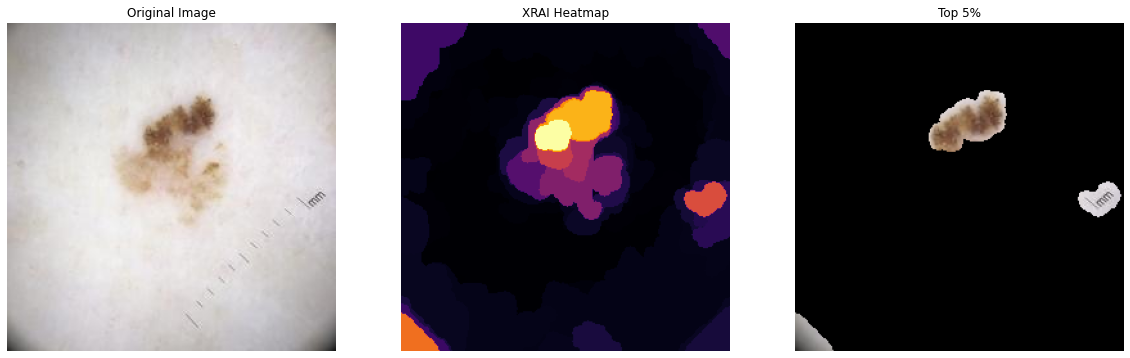

In [10]:
# Construct the saliency object. This alone doesn't do anthing.
xrai_object = saliency.XRAI()

# Compute XRAI attributions with default parameters
xrai_attributions = xrai_object.GetMask(im, call_model_function, call_model_args, batch_size=20)

# Set up matplot lib figures.
ROWS = 1
COLS = 3
UPSCALE_FACTOR = 20
P.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

# Show original image
utils.ShowImage(im_orig, title='Original Image', ax=P.subplot(ROWS, COLS, 1))

# Show XRAI heatmap attributions
utils.ShowHeatMap(xrai_attributions, title='XRAI Heatmap', ax=P.subplot(ROWS, COLS, 2))

# Show most salient 30% of the image
mask = xrai_attributions > np.percentile(xrai_attributions, 95)
im_mask = np.array(im_orig)
im_mask[~mask] = 0
utils.ShowImage(im_mask, title='Top 5%', ax=P.subplot(ROWS, COLS, 3))
plt.savefig('/workspace/Explainability_Dermatology/examples/PAIR/xrai_SAM_10', bbox_inches='tight')

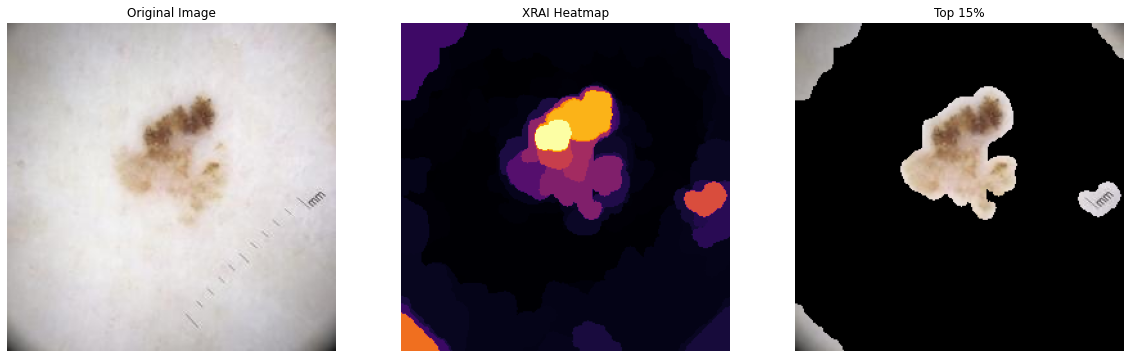

In [11]:
# Create XRAIParameters and set the algorithm to fast mode which will produce an approximate result.
xrai_params = saliency.XRAIParameters()
xrai_params.algorithm = 'fast'

# Compute XRAI attributions with fast algorithm
xrai_attributions_fast = xrai_object.GetMask(im, call_model_function, call_model_args, extra_parameters=xrai_params, batch_size=20)

# Set up matplot lib figures.
ROWS = 1
COLS = 3
UPSCALE_FACTOR = 20
P.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

# Show original image
utils.ShowImage(im_orig, title='Original Image', ax=P.subplot(ROWS, COLS, 1))

# Show XRAI heatmap attributions
utils.ShowHeatMap(xrai_attributions, title='XRAI Heatmap', ax=P.subplot(ROWS, COLS, 2))

# Show most salient 30% of the image
mask = xrai_attributions > np.percentile(xrai_attributions, 85)
im_mask = np.array(im_orig)
im_mask[~mask] = 0
utils.ShowImage(im_mask, title='Top 15%', ax=P.subplot(ROWS, COLS, 3))


### Guided IG

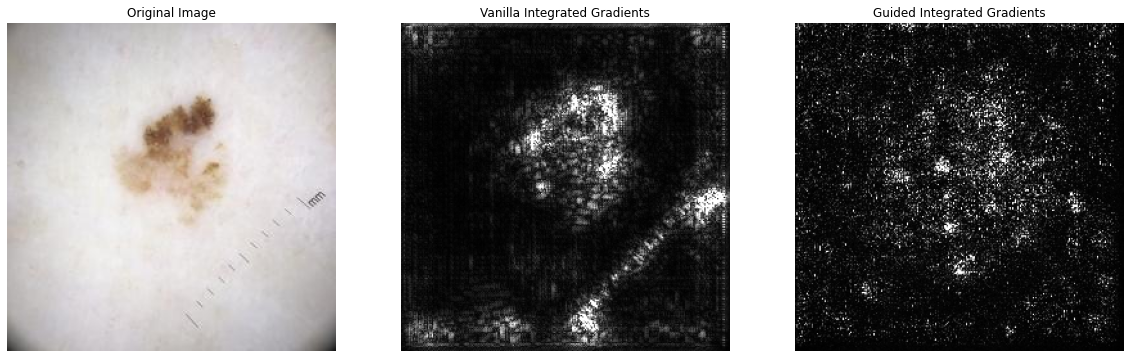

In [12]:
# Construct the saliency object. This doesn't yet compute the saliency mask, it just sets up the necessary ops.
integrated_gradients = saliency.IntegratedGradients()
guided_ig = saliency.GuidedIG()

# Baseline is a black image for vanilla integrated gradients.
baseline = np.zeros(im.shape)

# Compute the vanilla mask and the Guided IG mask.
vanilla_integrated_gradients_mask_3d = integrated_gradients.GetMask(
  im, call_model_function, call_model_args, x_steps=25, x_baseline=baseline, batch_size=20)
guided_ig_mask_3d = guided_ig.GetMask(
  im, call_model_function, call_model_args, x_steps=25, x_baseline=baseline, max_dist=1.0, fraction=0.5)

# Call the visualization methods to convert the 3D tensors to 2D grayscale.
vanilla_mask_grayscale = saliency.VisualizeImageGrayscale(vanilla_integrated_gradients_mask_3d)
guided_ig_mask_grayscale = saliency.VisualizeImageGrayscale(guided_ig_mask_3d)

# Set up matplot lib figures.
ROWS = 1
COLS = 3
UPSCALE_FACTOR = 20
P.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

# Render the saliency masks.
utils.ShowImage(im_orig, title='Original Image', ax=P.subplot(ROWS, COLS, 1))
utils.ShowGrayscaleImage(vanilla_mask_grayscale, title='Vanilla Integrated Gradients', ax=P.subplot(ROWS, COLS, 2))
utils.ShowGrayscaleImage(guided_ig_mask_grayscale, title='Guided Integrated Gradients', ax=P.subplot(ROWS, COLS, 3))
plt.savefig('/workspace/Explainability_Dermatology/examples/PAIR/IG_SAM_9',  bbox_inches='tight')